# Mean-shift algorithm from scratch
**Steps:**
1. Assign every single feature-set as cluster center.
2. Take all of the featuresets within the radius of the cluster center / within the bandwidth.
3. Take the mean of such featuresets obtained in step-2. This is the new cluster center.
4. Repeat step-3 until all the cluster centers are constant or move negligibly.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

In [2]:
# X = np.array([[1, 2],
#               [1.5, 1.8],
#               [5, 8],
#               [8, 8],
#               [1, 0.6],
#               [9, 11],
#               [8, 2],
#               [10, 2],
#               [9, 3],
#              ])

# Generate a random dataset
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=3, n_features=2)

colors = 10 * ['g', 'r', 'c', 'b', 'k']

In [3]:
class Mean_Shift:
    def __init__(self, radius=4):
        self.radius = radius
        
    def fit(self, data):
        centroids = {}
        for i in range(len(data)):
            centroids[i] = data[i]
            
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset - centroid) < self.radius:
                       in_bandwidth.append(featureset)
                
                new_centroid = np.average(in_bandwidth, axis=0)
                new_centroids.append(tuple(new_centroid))
            
            unique_centroids = sorted(list(set(new_centroids)))
            prev_centroids = dict(centroids)
            centroids = {}
            
            for i in range(len(unique_centroids)):
                centroids[i] = np.array(unique_centroids[i])
            
            optimized = True
            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                
                if not optimized:
                    break
                    
            if optimized:
                break
                
        self.centroids = centroids
        
    def predict(self, data):
        pass
                        

In [4]:
clf = Mean_Shift()
clf.fit(X)

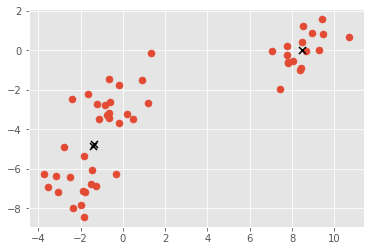

In [5]:
# Plotting
centroids = clf.centroids

plt.scatter(X[:, 0], X[:, 1], s=50)
for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], s=50, marker='x', color='k')
    
plt.show()

But if we decide the radius by looking at the dataset, then it is not exactly "unsupervised" learning. So, how to automate the process of computing the radius?

## Dynamic bandwidth

Let $C$ be the centroid of the entire dataset. We pre-define the `radius_norm_step` variable. Then, 
$$ Radius = \frac{\|C\|}{radius\_norm\_step} $$ 

In [6]:
class Mean_Shift_Dynamic_BW:
    def __init__(self, radius=None, radius_norm_step=100):
        self.radius = radius
        self.radius_norm_step = radius_norm_step
        
    def fit(self, data):
        
        if self.radius == None:
            all_data_centroid = np.average(data, axis=0)
            all_data_norm = np.linalg.norm(all_data_centroid)
            self.radius = all_data_norm / self.radius_norm_step
            
        centroids = {}
        for i in range(len(data)):
            centroids[i] = data[i]
        
        weights = [i for i in range(self.radius_norm_step)][::-1]
            
        while True:
            new_centroids = []
            
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                
                for featureset in data:
                    distance = np.linalg.norm(featureset - centroid)
                    if distance == 0:
                        distance = 1e-10
                    
                    weight_index = int(distance / self.radius)
                    if weight_index > self.radius_norm_step - 1:
                        weight_index = self.radius_norm_step - 1
                    
                    to_add = (weights[weight_index] ** 2) * [featureset]
                    in_bandwidth += to_add    
                
                new_centroid = np.average(in_bandwidth, axis=0)
                new_centroids.append(tuple(new_centroid))
            
            unique_centroids = sorted(list(set(new_centroids)))
            to_pop = []
            for i in unique_centroids:
                for j in unique_centroids:
                    if i == j:
                        pass
                    
                    elif np.linalg.norm(np.array(i) - np.array(j)) <= self.radius:
                        to_pop.append(j)
                        break
                        
            for i in to_pop:
                try:
                    unique_centroids.remove(i)
                except:
                    pass
                    
            prev_centroids = dict(centroids)
            centroids = {}
            for i in range(len(unique_centroids)):
                centroids[i] = np.array(unique_centroids[i])
            
            optimized = True
            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                
                if not optimized:
                    break
                    
            if optimized:
                break
                
        self.centroids = centroids
        self.classifications = {}
        for i in range(len(self.centroids)):
            self.classifications[i] = []
            
        for featureset in data:
            distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
            classification = distances.index(min(distances))
            self.classifications[classification].append(featureset)
        
    def predict(self, data):
        distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification
                        

In [7]:
clf = Mean_Shift_Dynamic_BW()
clf.fit(X)

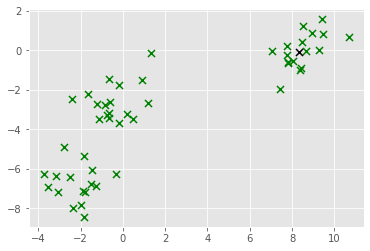

In [8]:
# Plotting
centroids = clf.centroids

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker='x', color=color, s=50)

# plt.scatter(X[:, 0], X[:, 1], s=50)
for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], s=50, marker='x', color='k')
    
plt.show()